In [ ]:
# in this one

In [125]:
from model.LTA_Stacked import LTA_Stacked
from model import load_model
import torch
from hvo_sequence.hvo_seq import HVO_Sequence
from hvo_sequence.drum_mappings import ROLAND_REDUCED_MAPPING
from bokeh.plotting import show, output_notebook
import os
import timeit
from hvo_sequence.hvo_seq import HVO_Sequence

output_notebook()

# mdl_ = 'misc/LTA/(Smaller) Predict 1 bar ahead, no velocity at inputs_w2ujjpkp/100.pth'
# mdl_ = 'misc/LTA/(Smaller) Predict 2 bar ahead, no velocity at inputs_ycwpquxg/100.pth'

# mdl_ = 'trained_models/(Smaller) Predict 1 bar ahead, no velocity at inputs_5yxlci4h_100.pth'
# mdl_ = 'trained_models/(Smaller) Predict 1 bar ahead, no velocity at inputs_w2ujjpkp_100.pth'
# mdl_ = 'trained_models/(Smaller) Predict 2 bar ahead, no velocity at inputs_ycwpquxg_100.pth'
mdl_ = 'misc/LTA_Stacked/Bass (LTA_Stacked) Predict 1 bar ahead, no velocity at inputs_ojodqmhh/060.pth'

model = load_model(
    model_path=mdl_,
    model_class=LTA_Stacked,
    device='cpu',
    is_evaluating=True
)

model.serialize(save_folder=os.path.dirname(mdl_), filename=mdl_.split('/')[-1].replace('.pth', '.pt'))
model.eval()

Loading BokehJS ...

StepEncoder: in_features: 20, out_features: 64
max_look_back_segments: 16
n_segments_per_bar:  16


LTA_Stacked(
  (StepEncoder): StepEncoder(
    (FCN): Sequential(
      (0): Linear(in_features=20, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (PositionalEncoding): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (TransformerEncoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=Fals

In [126]:
# load data
from data import StackedLTADatasetV2
max_n_bars = 16

test_dataset = StackedLTADatasetV2(
        input_inst_dataset_bz2_filepath="data/lmd/data_bass_groove_test.bz2",
        output_inst_dataset_bz2_filepath="data/lmd/data_drums_full_unsplit.bz2",
        shift_tgt_by_n_steps=1,
        max_input_bars=max_n_bars,
        hop_n_bars=4,
       input_has_velocity=False
    )

INFO:data.Base.dataLoaders:StackedLTADatasetV2 Constructor --> Loading Cached Version from: cached/TorchDatasets/StackedLTADatasetV2_data_bass_groove_test.bz2_data_drums_full_unsplit.bz2_16_4_1.bz2pickle


In [132]:
device = 'cpu'

def patch_attention(m):
    forward_orig = m.forward

    def wrap(*args, **kwargs):
        kwargs['need_weights'] = True
        kwargs['average_attn_weights'] = False

        return forward_orig(*args, **kwargs)

    m.forward = wrap
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []



# plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt


    
    
def get_hvo_seqs(groove_hvo__, drum_hvo__):
    if len(groove_hvo__.shape) == 3:
        groove_hvo_ = groove_hvo__[0]
    else:
        groove_hvo_ = groove_hvo__
        
    if len(drum_hvo__.shape) == 3:
        drum_hvo = drum_hvo__[0]
    else:
        drum_hvo = drum_hvo__
        
    hvo_seq_bass = HVO_Sequence(
        beat_division_factors=[4],
        drum_mapping={'BASS Rhythm': [80]}
    )
    hvo_seq_bass.add_tempo(0, 120)
    hvo_seq_bass.add_time_signature(0, 4, 4)
    hvo_seq_bass.hvo = groove_hvo_.detach().numpy()

    hvo_seq = HVO_Sequence(
        beat_division_factors=[4],
        drum_mapping=ROLAND_REDUCED_MAPPING
    )
    hvo_seq.add_tempo(0, 120)
    hvo_seq.add_time_signature(0, 4, 4)
    hvo_seq.hvo = drum_hvo.detach().numpy()
    
    audio_bass = hvo_seq_bass.synthesize(sf_path='hvo_sequence/soundfonts/Standard_Drum_Kit.sf2')
    audio_drums = hvo_seq.synthesize(sf_path='hvo_sequence/soundfonts/Standard_Drum_Kit.sf2')
    audio_mixed = audio_bass[:min(audio_bass.shape[0], audio_drums.shape[0])] + audio_drums[:min(audio_bass.shape[0], audio_drums.shape[0])]
    
    return hvo_seq_bass, hvo_seq, audio_bass, audio_drums, audio_mixed


def batch_data_extractor(data_, device=device):
    stacked_target_shifted = data_[0].to(device)
    stacked_target = data_[1].to(device)       
    return stacked_target_shifted, stacked_target

def forward_using_batch_data(batch_data, scope_end_step=None, model_=model, device=device):
    model_.train()

    stacked_target_shifted, stacked_target = batch_data_extractor(
        data_=batch_data,
        device=device
    )

    if scope_end_step is not None:
        scope_end_step = min(scope_end_step, stacked_target_shifted.shape[1])
        stacked_target_shifted = stacked_target_shifted[:, :scope_end_step, :]
        stacked_target = stacked_target[:, :scope_end_step, :]

    h_logits, v_logits, o_logits = model_.forward(shifted_tgt=stacked_target_shifted)

    return h_logits, v_logits, o_logits, stacked_target.to(device)
    

# Auto-regressive prediction
def predict_using_batch(batch_data, model_=model, device='cpu'):
    model_.eval()
    
    
    stacked_target_shifted, stacked_target = batch_data_extractor(
        data_=batch_data,
        device=device
    )
    
    h_logits, v_logits, o_logits, _ = forward_using_batch_data(
        batch_data=batch_data,
        scope_end_step=max_n_bars * 16,
        model_=model_,
        device=device
    )
    
    h = torch.sigmoid(h_logits)
    h[h < 0.3] = 0.0
    h[h >= 0.3] = 1.0
    v = torch.clamp(((torch.tanh(v_logits) + 1.0) / 2), 0.0, 1.0) * h
    o = torch.tanh(o_logits) * h
    
    groove_hvo = torch.zeros((h.shape[0], h.shape[1], 3))
    drum_hvo = torch.zeros((h.shape[0], h.shape[1], 27))
    
    groove_hvo[:, :, 0] = h[:, :, 0] 
    groove_hvo[:, :, 1] = v[:, :, 0]
    groove_hvo[:, :, 2] = o[:, :, 0]
    
    drum_hvo[:, :, :9] = h[:, :, 1:10]
    drum_hvo[:, :, 9:18] = v[:, :, 1:10]
    drum_hvo[:, :, 18:] = o[:, :, 1:10]
    
    return groove_hvo, drum_hvo
    

sample_ix = torch.randint(0, len(test_dataset), (1,)).item()
groove_hvo, drum_hvo = predict_using_batch(test_dataset[sample_ix:sample_ix+1], model_=model, device='cpu')
hvo_seq_bass, hvo_seq_drum, audio_bass, audio_drums, audio_mixed = get_hvo_seqs(groove_hvo, drum_hvo)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [133]:
from IPython.display import Audio, display
display(Audio(audio_mixed, rate=44100))
hvo_seq_bass.to_html_plot(show_figure=True, width=1400, height=200)

Figure(id='46535', ...)

In [134]:
hvo_seq_drum.to_html_plot(show_figure=True, width=1400, height=200)


Figure(id='47808', ...)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f26fe720970>


torch.Size([1, 4, 256, 256])


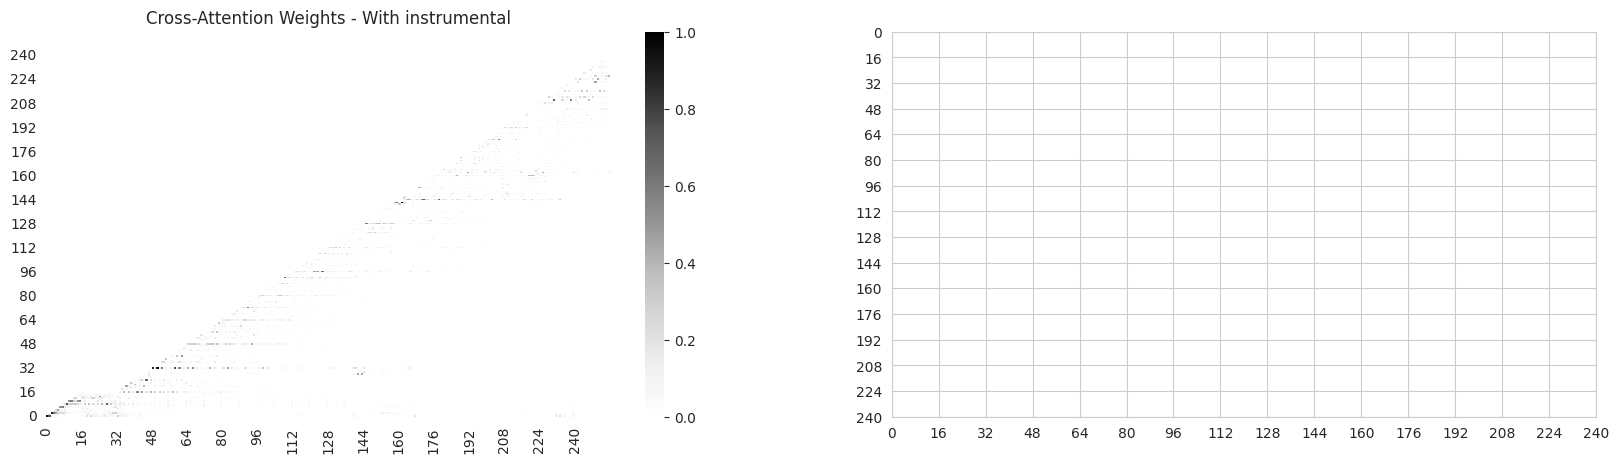

In [135]:
def plot_head_n_attention(head_n, attn_weights_list,  binary_vis=False):
    attn_weights = attn_weights_list[0]
    print(attn_weights.shape)
    if head_n is None:
        # sum across all heads

        attn_weights_0 = attn_weights.sum(dim=1, keepdim=True).detach().cpu().numpy()
    else:

        attn_weights_0 = attn_weights.detach().cpu().numpy()
    
        
    if binary_vis:
        attn_weights_0 = attn_weights_0 > 0.01
        

    # two side by side plots
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    # use a greyscale color map
    sns.heatmap(attn_weights_0[0, head_n if head_n is not None else 0, :, :].transpose(), cmap='Greys', ax=ax[0])
    ax[0].set_title('Cross-Attention Weights - With instrumental')

    # put ticks on 0, 4, ...
    # rotate y ticks

    for a in ax:
        a.set_xticks([i for i in range(0, max_n_bars*16, 16)])
        a.set_xticklabels([i for i in range(0, max_n_bars*16, 16)])
        a.set_yticks([i for i in range(0, max_n_bars*16, 16)])
        a.set_yticklabels([i for i in range(0, max_n_bars*16, 16)])
        a.set_yticklabels(a.get_yticklabels(), rotation=0)

    # flip y axis
    for a in ax:
        a.invert_yaxis()

    plt.show()

save_output = SaveOutput()

layer_ix = 3

patch_attention(model.TransformerEncoder.layers[layer_ix].self_attn)
hook_handle = model.TransformerEncoder.layers[layer_ix].self_attn.register_forward_hook(save_output)

groove_hvo, drum_hvo = predict_using_batch(test_dataset[sample_ix:sample_ix+1], model_=model, device='cpu')

plot_head_n_attention(2, save_output.outputs, binary_vis=False)


In [90]:
len(save_output.outputs)

1